# Detecting heart disease using machine learning

In [ ]:
# Import packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from sklearn.model_selection import cross_validate
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Import machine learning models
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

## First look at the data

The data is a heart failure prediction dataset, obtained from Kaggle and can be found [here](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?resource=download).

In [20]:
# Read the data from CSV file and make sure the numbering starts at 1 instead of 0
heart_data = pd.read_csv("heart.csv")
heart_data.index += 1 

heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
1,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
2,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
3,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
4,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
5,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [ ]:
heart_data.shape

(918, 12)

This data contains a total of 918 instances (patients) and 12 different features, of which some very standard features such as '`age`' (numerical) and '`sex`' (categorical). Other than that there are features of different datatypes. There are numeric features: `RestingBP`, `Cholesterol`, `MaxHR`, and `Oldpeak`. And there are categorical (class) features such as `ChestPainType`, `RestingECG`, `FastingBS` and `ST_Slope`. Lastly, there are 2 dichotome features (booleans), which are `ExerciseAngina` and `HeartDisease`. These two features are either true or false.

## Research question/purpose:
Using this dataset I want to predict the presence or absence of heart disease in humans, based on the aforementioned features. This dataset contains only patients with or without heart disease, which is displayed with a 0 (absence) or a 1 (presence). Using this model, a new patient can be analysed on the afore mentioned features and the outcome will either be a 0 or a 1. A 1 not necessarily meaning the presence of heart disease, but it does mean that the symptomatic profile of the patient is similar to that of a patient with heart disease. This indicates *further cardiologic research is needed for the patient to be able to fully determine the presence of heart disease*. 


I created a codebook below, using [the attribute information](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?resource=download). Here I specify the unit and datatype per feature (attribute) and add a short description. For now I will be looking at all of the features, as I do not want to select beforehand. I will treat each attribute equally for now and will later make a selection on which features are most informative.

In [21]:
codebook = {
    "attribute": ["Age", "Sex", "ChestPainType", "RestingBP", "Cholesterol", "FastingBS", "RestingECG", "MaxHR", "ExerciseAngina", "Oldpeak", "ST_Slope", "HeartDisease"],
    "unit": ["years", "-", "-", "mm Hg", "mg/dl", "mg/dl", "-", "BPM", "-", "-", "-", "-"],
    "dtype": ["int32", "category", "category", "int32", "int32", "category", "category", "int32", "category", "int32", "category", "category"],
    "description": [
        "Age of the patient", 
        "Sex of the patient", 
        "Chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]", 
        "Resting blood pressure (systolic)", 
        "Serum cholesterol", 
        "Fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]", 
        "Resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]", 
        "Maximum heart rate achieved [Numeric value between 60 and 202]", 
        "Exercise-induced angina [Y: Yes, N: No]", 
        "ST [Numeric value measured in depression]", 
        "The slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]", 
        "Output class [0: no heart disease, 1: heart disease]"
        ]
}

pd.DataFrame(codebook).set_index("attribute")

,unit,dtype,description
attribute,,,
Age,years,int32,Age of the patient
Sex,-,category,Sex of the patient
ChestPainType,-,category,"Chest pain type [TA: Typical Angina, ATA: Atyp..."
RestingBP,mm Hg,int32,Resting blood pressure (systolic)
Cholesterol,mg/dl,int32,Serum cholesterol
FastingBS,mg/dl,category,Fasting blood sugar [1: if FastingBS > 120 mg/...
RestingECG,-,category,Resting electrocardiogram results [Normal: Nor...
MaxHR,BPM,int32,Maximum heart rate achieved [Numeric value bet...
ExerciseAngina,-,category,"Exercise-induced angina [Y: Yes, N: No]"


Now I will convert all columns to the set datatypes.

In [22]:
for column, dtype in zip(codebook["attribute"], codebook["dtype"]):
    heart_data[column] = heart_data[column].astype(dtype)
    
pd.DataFrame({
    "dtypes": heart_data.dtypes
})

,dtypes
Age,int32
Sex,category
ChestPainType,category
RestingBP,int32
Cholesterol,int32
FastingBS,category
RestingECG,category
MaxHR,int32
ExerciseAngina,category
Oldpeak,int32


## Closer look at the different attributes:

Some attributes, such as age are self explanatory, however there are some other attributes that could use some further explanation. Below I give extra info for these attributes, in order to get a better understanding.

### ChestPainType
Possible options are:
- `TA`: Typical Angina;
- `ATA`: Atypical Angina;
- `NAP`: Non-Anginal Pain;
- `ASY`: Asymptomatic. 

*Angina (pectoris)* is chestpain caused by reduced bloodflow to the heart. It can present itself in two general ways, '`typical`' and '`atypical`'. It is classified as '`typical`' when the following three characteristics are present (Baggiano et al., 2020):

- Discomfort under the sternum of characteristic intensity and duration;
- The chest pain is provoked by (physical) exertion or emotional stress; 
- The chest pain is relieved with rest and/or specific medicine (strong vasodilators) within minutes.

When only 2 of the characteristics are present, the chest pain is classified as '`atypical`'. If only one or none of the characteristics are present, the chest pain is classified as '`non-anginal pain`'. The fourth category in the data, '`asymptomatic`', suggests that there are no chest-pain related symptoms present.


### Cholesterol
This attribute is not very clear described, the description that comes with the dataset only states "**serum cholesterol**". However there are multiple types of serum cholesterol in humans, which include (Jung et al., 2022):

- High-density lipoprotein cholesterol (`HDL-C`);
- Low-density lipoprotein cholesterol (`LDL-C`);
- Very low-density of lipoprotein (`VLDL`).

As it is not stated which one of these types of cholesterols is measured, I will assume that the total serum cholesterol is measured, which includes all of the 3 subtypes. In the data a lot of the patients seem to have a cholesterol value of 0, which does not seem very likely. I did some further research on what a minimum serum cholesterol would have to be for an individual to survive. According to Fazio en Linton (2001) LDL cholesterol plays an important role in transporting vitamin A and vitamin E and in transporting cholesterol to tissues. Already at LDL levels between 50-75 mg/dl there could be a potential health risk for the patient. And Ahmed et al. (2016) found that patients with low HDL cholesterol levels (<40 mg/dl for men and <50 mg for women) had higher prevalence in hypertension and diabetes. Judging from this information it is very likely the '0' values for cholesterol are simply missing values and thus I will be removing them.



### RestingECG
This attribute is categorical and contains the following options:

- `Normal`: Normal;
- `ST`: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV);
- `LVH`: showing probable or definite left ventricular hypertrophy by Estes' criteria .

Assuming from the attribute name, the ECG was taken when the patient was in rest. A normal ECG is defined like the one below (MedSchool, n.d.):

<img src="img/normal_ecg.gif" alt="Normal ECG" width="300">

Containing the following characteristics:

- P and T are defined by a slight upwards, round slope
- Q and S are defined by a slight downwards 'dip'
- R is defined by a steep, sharp slope

For the label `ST`, it means the patient has some kind of abnormality in the slope for either both S and T or only T. This includes T-wave inversions, where the T-slope goes down instead of upwards. It also includes ST elevation/depression, where the area between the ST slope is either elevated or lowered compared to a normal ECG. Below are images of a T-wave inversion (Ranjbar et al., 2021) and a ST elevation/depression (pulsenotes, n.d.).

<img src="img/inverted_t_wave.webp" alt="Inverted T-Wave" width="300">


<img src="img/st_elevation_st_depression.jpeg" alt="ST_elevation/Depression" width="300">

The third label (`LVH`) is determined by checking on `Romhilt-Estes' criteria`, these are in total 6 criteria that describe whether a patient (likely) has `Left Ventricular Hypertrophy` (LVH), which is a thickening of the wall of the left ventricle.

The criteria are (MSD Manuals, 2025):

- Biggest R or S wave in the limb leads greater than or equal to 20 mm; or S wave in V1 or V2 greater than or equal to 30 mm; or R wave in V5 or V6 greater than or equal to 30 mm (3 points);
- Left atrial involvement - terminal deflection of P wave in V1 is 1 box wide, and 1 box deep or more (3 points);
- Left axis deviation - QRS axis is -30 degrees or more negative (2 points);
- QRS duration greater than or equal to 0.09 second (1 point);
- Intrinsicoid deflection in V5 and V6 greater than or equal to 0.05 second (1 point);
- ST-T segment changes ("LV strain" = ST-T vector shifted opposite to QRS vector)
    - Without digitalis (3 points)
    - With digitalis (1 point)

The total number of points that can be scored is 13 and a score between 5-13 indicates a presence of `LVH`, whereas 4 points indicates on a *likely* presence of `LVH`. A score of 0-3 points indicate an *unlikely* presence of LVH (MSD Manuals, 2025). So for a patient to get the label `LVH`, they will have to have scored at least 4 points on Romhilt-Estes' criteria.

## OldPeak
Numerical value that displays the degree of 'ST depression', measured with the PR-segment as baseline. The Oldpeak is the height difference in millimeters between the PR-segment and the J-point, see image below for illustration (Rawshani, 2019).

<img src="img/ST_depression.PNG" alt="ST_depression/elevation" width="400">

## ST_Slope
The ST_slope attribute describes the angle of the slope between the ST segment, this can be either upsloping, flat (horizontal) or downsloping. In the image below the different slopes are illustrated (Rahman et al., 2022).

<img src="img/ST_slope.png" alt="ST_Slope" width="400">



## Explorative Data Analysis (univariate)



In [115]:
pd.DataFrame({
    "isna": heart_data.isna().sum()
})

,isna
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


**Conclusion**:

- There are no missing values

A lot of the features are numerical (Age, RestingBP, Cholesterol, MaxHR, Oldpeak), so we can use .describe() to show the distributions

In [ ]:
heart_data.describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.720044
std,9.432617,18.514154,109.384145,25.460334,0.990165
min,28.000000,0.000000,0.000000,60.000000,-2.000000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.000000
75%,60.000000,140.000000,267.000000,156.000000,1.000000
max,77.000000,200.000000,603.000000,202.000000,6.000000


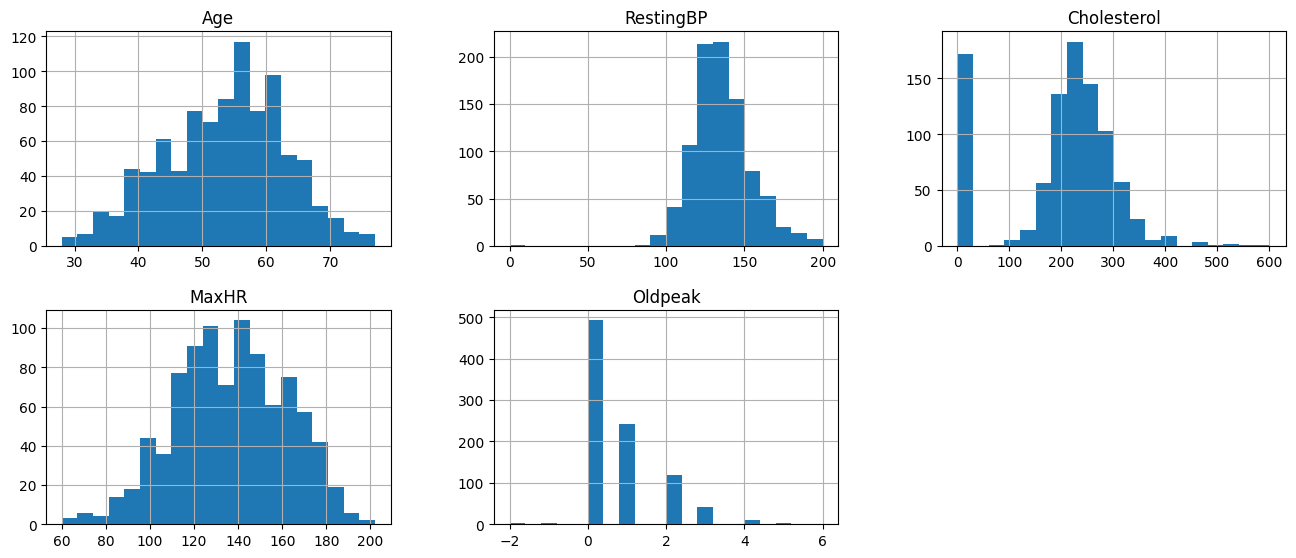

In [36]:
heart_data.hist(bins=20, layout=(2, 3), figsize=(16.0, 6.4));

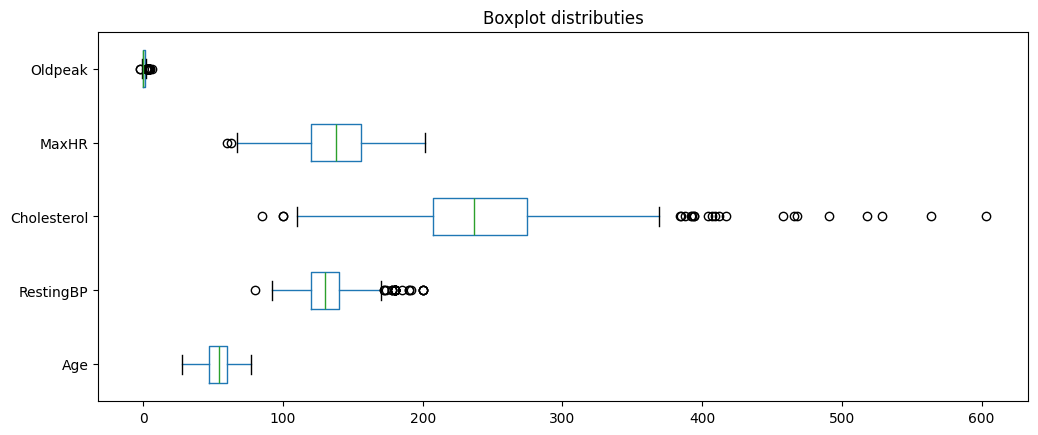

In [ ]:
axs = heart_data.boxplot(grid=False, vert=False, figsize=(12.0, 4.8))
axs.set_title("Boxplot distributies");

**Conclusion:**
- The patients ages range from 28-77 with the average age being 53 years old;
- `Age`, `RestingBP` and `MaxHR` seem to be normally distributed;
- `Cholesterol` seems to be normally distributed, but seems to have a tall peak at a value of 0;
- There seems to be missing values for RestingBP, as this cannot be equal to 0;
- `Oldpeak` seems to have an non-continuous distribution.

I will remove the 0 values for `Cholesterol` and `RestingBP`. Blood pressure can not be equal to 0 as that would mean that the patients heart is not beating. For cholesterol I had done some additional research, before deciding to remove the 0 values, which I describe [here](#cholesterol).

I replace the removed 0 values for both columns, as most machine learning models can not work with NaN values. I replace the missing `Cholesterol` and `RestingBP` values with the median, as they both have a lot of high outliers, which affects the mean but not the median.

In [23]:
heart_data.loc[heart_data["Cholesterol"] == 0, "Cholesterol"] = np.nan
heart_data.loc[heart_data["RestingBP"] == 0, "RestingBP"] = np.nan

pd.DataFrame(heart_data[["Cholesterol", "RestingBP"]].describe())

,Cholesterol,RestingBP
count,746.000000,917.000000
mean,244.635389,132.540894
std,59.153524,17.999749
min,85.000000,80.000000
25%,207.250000,120.000000
50%,237.000000,130.000000
75%,275.000000,140.000000
max,603.000000,200.000000


In [24]:
heart_data["Cholesterol"] = heart_data["Cholesterol"].fillna(heart_data["Cholesterol"].median())
heart_data["RestingBP"] = heart_data["RestingBP"].fillna(heart_data["RestingBP"].mean())

**Conclusion**:

- The invalid '0' values have been succesfully removed from the `Cholesterol` and `RestingBP` columns and are both normally distributed now. 

In [25]:
logdata = np.log10(heart_data[["Cholesterol", "RestingBP", "Age", "MaxHR"]]);

logdata.describe()

,Cholesterol,RestingBP,Age,MaxHR
count,918.000000,918.000000,918.000000,918.000000
mean,2.376202,2.118450,1.721234,2.128070
std,0.092025,0.058032,0.080771,0.085460
min,1.929419,1.903090,1.447158,1.778151
25%,2.330414,2.079181,1.672098,2.079181
50%,2.374748,2.113943,1.732394,2.139879
75%,2.426511,2.146128,1.778151,2.193125
max,2.780317,2.301030,1.886491,2.305351


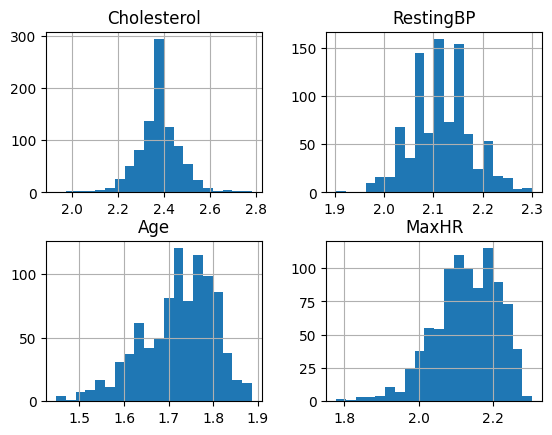

In [60]:
logdata.hist(bins=20, layout=(2, 2));

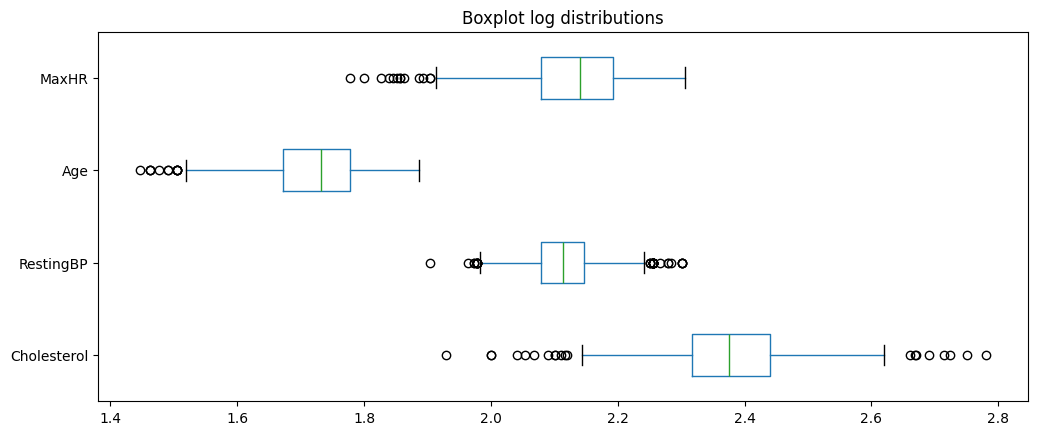

In [51]:
axs = logdata.boxplot(grid=False, vert=False, figsize=(12.0, 4.8))
axs.set_title("Boxplot log distributions");

**Conclusion**:
- The log transformation made `Cholesterol` and `RestingBP` more normally distributed
- The log transformation made `Age` and `MaxHR` less normally distributed
- The outliers seem less extreme for `Cholesterol`

In [26]:
for attribute in ("Cholesterol", "RestingBP"):
    index = codebook["attribute"].index(attribute)
    newname = "log(" + attribute + ")"
    codebook["attribute"][index] = newname
    codebook["unit"][index] = "-"
    codebook["description"][index] = "Log10-transform of " + codebook["description"][index]
    heart_data.rename(columns={attribute: newname}, inplace=True)
    heart_data[newname] = logdata[attribute]

pd.DataFrame(codebook).set_index("attribute")

,unit,dtype,description
attribute,,,
Age,years,int32,Age of the patient
Sex,-,category,Sex of the patient
ChestPainType,-,category,"Chest pain type [TA: Typical Angina, ATA: Atyp..."
log(RestingBP),-,int32,Log10-transform of Resting blood pressure (sys...
log(Cholesterol),-,int32,Log10-transform of Serum cholesterol
FastingBS,mg/dl,category,Fasting blood sugar [1: if FastingBS > 120 mg/...
RestingECG,-,category,Resting electrocardiogram results [Normal: Nor...
MaxHR,BPM,int32,Maximum heart rate achieved [Numeric value bet...
ExerciseAngina,-,category,"Exercise-induced angina [Y: Yes, N: No]"


**Conclusion**
- `Cholesterol` and `RestingBP` are now log transformed.

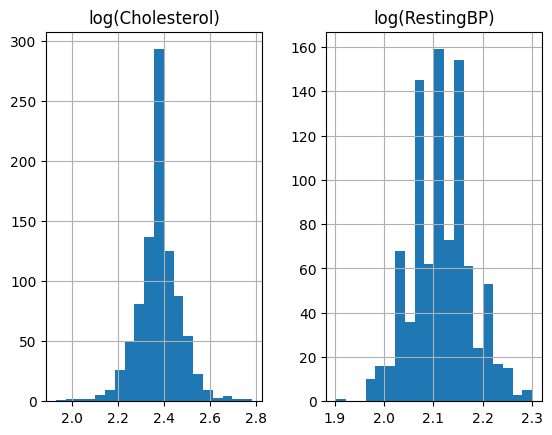

In [62]:
heart_data[["log(Cholesterol)", "log(RestingBP)"]].hist(bins=20);

# Explorative Data Analysis (bivariate)

Now I will calculate and visualise correlations between features. First, I will look at the distribution of numerical features across sexes.

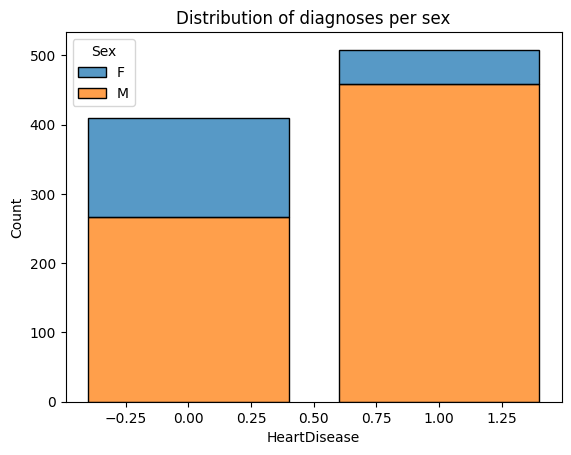

In [ ]:
axs = sns.histplot(heart_data, x="HeartDisease", hue="Sex", multiple="stack", shrink=0.8)
axs.set_title("Distribution of diagnoses per sex");


**Conclusion**:
- There seem to be more patients **with** heart disease than without;
- The majority of the patients is male;
- The majority of patients in this dataset with heart disease are male.

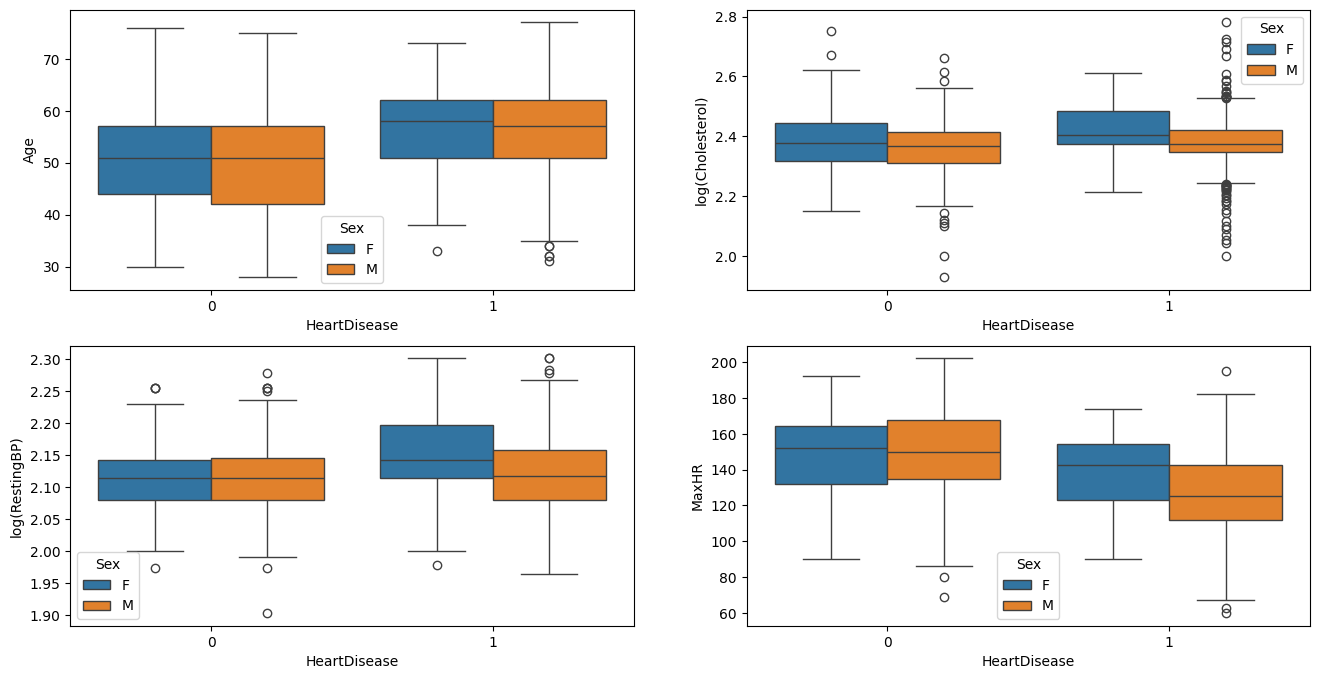

In [65]:
fig = plt.figure(figsize=(16.0, 8.0))
for index, attribute in enumerate(("Age", "log(Cholesterol)", "log(RestingBP)", "MaxHR")):
    axs = fig.add_subplot(2, 2, index+1)
    sns.boxplot(heart_data, x="HeartDisease", y=attribute, hue="Sex", ax=axs)
plt.show()

**Conclusion:**

- People with heart disease seem to be **older** on average than people without heart disease;
- The `Age` distribution seems similar in both sexes;
- `Cholesterol` levels seem to be a bit higher on average in those with heart disease, however in both groups (with/without heart disease) there seem to be some outliers with high cholesterol levels;
- The `RestingBP` seems to be slightly higher in patients with heart disease, but mostly the range seems to have increased;
- The `MaxHR` seems to be higher in those without heart disease;

Next, I'm making a general overview of the numerical features, sorted by heart disease/no heart disease.

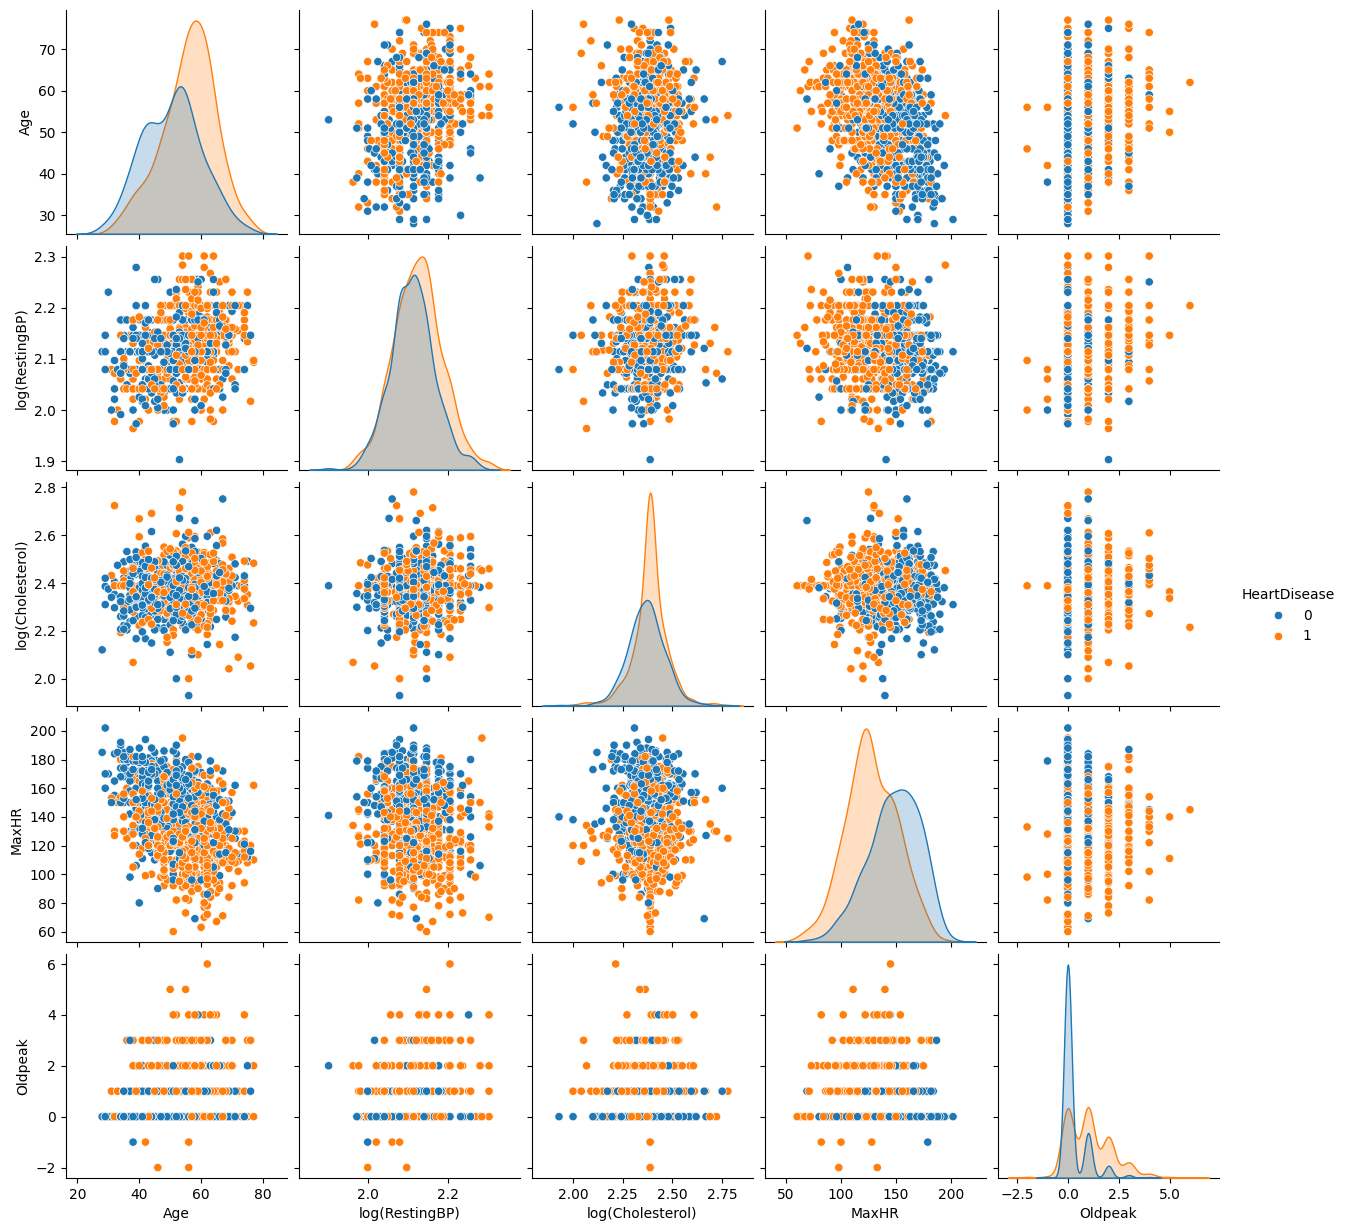

In [44]:
sns.pairplot(heart_data, hue="HeartDisease");

**Conclusion**:
- Some of the data shows a visible seperation "line" between the cases with and without heart disease. This is seen in the attributes `MaxHR`, `Age`, `RestingBP` and `Cholesterol`. This is a good indicator that this dataset is suited for creating a machine learning model;
- `Oldpeak` seems to have a very different distribution from the other numerical features, this is likely caused by the way oldpeak is measured, as it measures the amount of millimeter the PR segment differs from the J point. This is measured on ECG paper, with small boxes that are each one millimeter, for this likely whole millimeters or boxes are being used, to keep the measuring of this aspect more constant across instances.

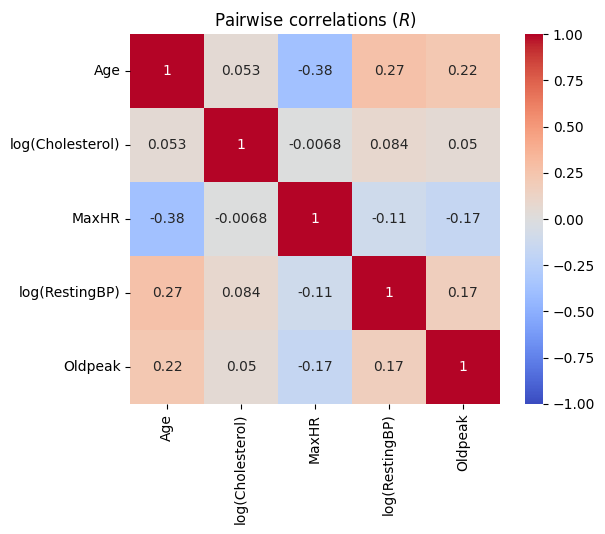

In [64]:
# only select numerical data
numeric_heart_data = heart_data[["Age", "log(Cholesterol)", "MaxHR", "log(RestingBP)", "Oldpeak"]]

axs = sns.heatmap(numeric_heart_data.corr(), annot=True, cmap="coolwarm", vmin=-1.0, vmax=1.0, square=True)
axs.set_title("Pairwise correlations ($R$)");


**Conclusion**:
- There seems to be a moderate negative correlation between `Age` and `MaxHR` (R=-0.38), meaning the higher the age of the patient, the lower the maximum heart rate on average;
- There seems to be a slight positive correlation between `log(RestingBP)` and `Oldpeak` with `Age` (R=0.27 and R=0.22), so the older the patient, the higher the `log(RestingBP)` and `Oldpeak`;
- All other "correlations" seem very weak.

Next I will check the statistical significance (p) and practical significance (η2) of the correlation of each numerical feature with the class label, by using a **1-way ANOVA analysis**. Here, `k` is the number of classes, `N` is the number of instances and `F` is the F-statistic.

In [ ]:
Ngroups = heart_data["HeartDisease"].nunique()

# 1-way ANOVA
def anova_stats(attribute):
    groupdata = [data[attribute].dropna().tolist() for _, data in heart_data.groupby("HeartDisease")]
    Ntotal = sum(len(data) for data in groupdata)
    F, p = stats.f_oneway(*groupdata)
    η2 = F * (Ngroups-1) / (F * (Ngroups-1) + Ntotal-Ngroups)
    return F, p, η2

anova = {attribute: anova_stats(attribute) for attribute in heart_data.select_dtypes(include='number').columns}

pd.DataFrame(anova, index=["F", "p", "η2"]).T

/tmp/ipykernel_1962066/802096812.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groupdata = [data[attribute].dropna().tolist() for _, data in heart_data.groupby("HeartDisease")]


,F,p,η2
Age,79.160779,3.007953e-18,0.079546
log(RestingBP),11.914094,5.825816e-04,0.012840
log(Cholesterol),6.967753,8.440226e-03,0.007549
MaxHR,174.913585,1.137786e-36,0.160337
Oldpeak,166.699195,3.699537e-35,0.153966


**Conclusion**:

- All features display a statistically signicifant association with the diagnosis (`p <0.05`)

For eta squared, the scores can be interpreted as:
- `η2` = 0.01 indicates a small effect
- `η2` = 0.06 indicates a medium effect
- `η2` = 0.14 indicates a large effect

- This means that `MaxHR` and `Oldpeak` have a strong association with the label and that `Age`, `RestingBP` and `Cholesterol` have a small to medium association with the label.

Below the features are ranked on how strong the association is between the feature and the class label (based off of the value for `F`):
1. `MaxHR`;
2. `Oldpeak`;
3. `Age`;
4. `log(RestingBP)`;
5. `log(Cholesterol)`.


Now I will do the same, but for the categorical features. Here I test the statistic significance (`p`) and practical significance (`Cramer's V2`) of the correlation with each categorical feature with the class label, using a **2-way Chi-squared analysis**.

In [ ]:
# 2-way Chi-squared
def chi2_stats(attribute):
    table = pd.crosstab(heart_data[attribute], heart_data["HeartDisease"])
    χ2, p, *_ = chi2_contingency(table)
    V2 = association(table) ** 2
    return χ2, p, V2

chi2 = {attribute: chi2_stats(attribute) for attribute in heart_data.select_dtypes(include='category').columns}

pd.DataFrame(chi2, index=["χ2", "p", "V2"]).T

,χ2,p,V2
Sex,84.145101,4.597617e-20,0.093297
ChestPainType,268.067239,8.083728e-58,0.292012
FastingBS,64.320679,1.057302e-15,0.071445
RestingECG,10.931469,4.229233e-03,0.011908
ExerciseAngina,222.259383,2.907808e-50,0.244315
ST_Slope,355.918443,5.167638e-78,0.387711
HeartDisease,913.958347,9.067123e-201,1.000000


**Conclusion**:

- All features show statistically significant association with the diagnosis (`p <0.05`)

For Cramer's V, the scores can be interpreted as:
- 0	    = No association
- 0.1	= Weak association
- 0.3	= Moderate association
- 0.5	= Strong association
- 1	    = Perfect association

- All features show a weak to medium association with the diagnosis, except for `HeartDisease`, which obviously shows a perfect association with itself

Below, the features are ranked on how strong the association is between the feature and the class label (based off of the value for *X2*, not counting HeartDisease):
1. `ST_Slope`;
2. `ChestPainType`;
3. `ExerciseAngina`;
4. `Sex`;
6. `FastingBS`;
7. `RestingECG`.


### Machine Learning

This dataset contains a lot of categorical (nominal) features. Most machine learning models cannot work with strings as features, so the labels will have to be converted to integers. However by just changing each feature value to a number, the models might think there is a certain order to them, when in reality there is not. E.g. `ChestPainType_ASY` = 1.0, `ChestPainType_ATA` = 2.0,  `ChestPainType_NAP` = 3.0, `ChestPainType_TA` = 4.0. Instead I will use one-hot encoding to make all values remain equal, but still convert them to integers so that the machine learning models can work with them. 

In [27]:
# Separate categorical and numerical data
X_cat = heart_data[["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope", "FastingBS"]]
X_num = heart_data[["Age", "log(RestingBP)", "log(Cholesterol)", "MaxHR", "Oldpeak", "HeartDisease"]]

In [28]:
# One-hot encoding of categorical features
encoder = OneHotEncoder(sparse_output=False)

X_encoded = encoder.fit_transform(X_cat)

# Create column names for newly one-hot encoded features and merge in dataframe
categorical_columns = [f'{col}_{cat}' for i, col in enumerate(X_cat.columns) for cat in encoder.categories_[i]]

one_hot_features = pd.DataFrame(X_encoded, columns=categorical_columns, index=heart_data.index)


In [29]:

# Combine the numerical and the one-hot encoded categorical features
X_processed = pd.concat([one_hot_features, X_num], axis=1)

print(X_processed.head())

   Sex_F  Sex_M  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
1    0.0    1.0                0.0                1.0                0.0   
2    1.0    0.0                0.0                0.0                1.0   
3    0.0    1.0                0.0                1.0                0.0   
4    1.0    0.0                1.0                0.0                0.0   
5    0.0    1.0                0.0                0.0                1.0   

   ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
1               0.0             0.0                1.0            0.0   
2               0.0             0.0                1.0            0.0   
3               0.0             0.0                0.0            1.0   
4               0.0             0.0                1.0            0.0   
5               0.0             0.0                1.0            0.0   

   ExerciseAngina_N  ...  ST_Slope_Flat  ST_Slope_Up  FastingBS_0  \
1               1.0  ...           

In [30]:
# Update codebook with new features
new_features = {
    "attribute": [
        "Sex_F", "Sex_M", "ChestPainType_ASY", "ChestPainType_ATA", "ChestPainType_NAP", 
        "ChestPainType_TA", "RestingECG_LVH", "RestingECG_Normal", "RestingECG_ST", 
        "ExerciseAngina_N", "ExerciseAngina_Y", "ST_Slope_Down", "ST_Slope_Flat", "ST_Slope_Up", 
        "FastingBS_0", "FastingBS_1", "Age", "log(RestingBP)", "log(Cholesterol)", 
        "MaxHR", "Oldpeak", "HeartDisease"
        ],
    "unit": [
        "-", "-", "-", "-", "-", "-", "-", "-", "-", "-", "-", "-", "-", 
        "-", "-", "-", "years", "mm Hg", "mg/dl", "BPM", "-",  "-"
        ],
    "dtype": [
        "category", "category", "category", "category", "category", "category", "category", "category", 
        "category", "category", "category", "category", "category", "category", "category", "category",
        "int32", "int32", "int32", "int32", "int32", "category"
        ],
    "description": [
        "One-hot encoded: Sex of the patient [female]",
        "One-hot encoded: Sex of the patient [male]",
        "One-hot encoded: Chest pain type [ASY: Asymptomatic]",
        "One-hot encoded: Chest pain type [ATA: Atypical Angina]",
        "One-hot encoded: Chest pain type [NAP: Non-Anginal Pain]",
        "One-hot encoded: Chest pain type [TA: Typical Angina]",
        "One-hot encoded: Resting electrocardiogram results [LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]", 
        "One-hot encoded: Resting electrocardiogram results [Normal: Normal]",
        "One-hot encoded: Resting electrocardiogram results [ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)]",
        "One-hot encoded: Exercise-induced angina [N: No]", 
        "One-hot encoded: Exercise-induced angina [Y: Yes]",
        "One-hot encoded: The slope of the peak exercise ST segment [Down: downsloping]", 
        "One-hot encoded: The slope of the peak exercise ST segment [Flat: flat]",
        "One-hot encoded: The slope of the peak exercise ST segment [Up: upsloping]",
        "One-hot encoded: Fasting blood sugar [0: otherwise]", 
        "One-hot encoded: Fasting blood sugar [1: if FastingBS > 120 mg/dl]",
        "Age of the patient", 
        "log(Resting blood pressure (systolic))",
        "log(Serum cholesterol)", 
        "Maximum heart rate achieved [Numeric value between 60 and 202]", 
        "ST [Numeric value measured in depression]", 
        "Output class [0: no heart disease, 1: heart disease]"

    ]
}

# Add to codebook
codebook.update(new_features)


In [31]:
# X = all columns except last, y is vector of only last
X = X_processed.iloc[:, :-1].to_numpy()
y = X_processed.iloc[:,-1].to_numpy()


In [32]:
# Define models
models = [
    DummyClassifier,
    DecisionTreeClassifier,
    LinearDiscriminantAnalysis,
    GaussianNB,
    KNeighborsClassifier,
    RandomForestClassifier,
    AdaBoostClassifier
]

In [33]:
metric_scores = {}
for model in models:
    scores = cross_validate(model(), X, y, cv=2, return_train_score=True)
    for key, val in scores.items():
        scores[key] = val.mean()
    metric_scores[f"{model.__name__}"] = scores
    
pd.DataFrame(metric_scores).T

,fit_time,score_time,test_score,train_score
DummyClassifier,0.046099,0.130652,0.553377,0.553377
DecisionTreeClassifier,0.139980,0.021320,0.751634,1.000000
LinearDiscriminantAnalysis,0.625336,0.015266,0.821351,0.880174
GaussianNB,0.017448,0.009016,0.816993,0.869281
KNeighborsClassifier,0.282081,4.861620,0.689542,0.807190
RandomForestClassifier,0.974219,0.028626,0.806100,1.000000
AdaBoostClassifier,0.291853,0.013677,0.824619,0.884532


**Conclusion**:

- The `RandomForestClassifier` is slowest with fitting and the `KNeighborsClassifier` is the slowest with scoring
- As expected, the `DummyClassifier` performs the worst out of all the models (score=0.55)
- The `DecisionTreeClassifier` and `RandomForestClassifier` are overfitting, which is seen by the perfect performance on the training dataset and a much lower performance for the test dataset, `KNeighborsClassifier` and `AdaBoostClassifier` also seem to overfit, but not as much.
- `GaussianNB` seems to be the best choice, as it is not overfitting (similar train and testscores) and it is very time efficient compared to some of the other models. 


Now I will check how many features GaussianNB needs, in order to get the highest possible `test_score`:

In [34]:
metric_scores = {}
k = 7

while k:
    X_select = SelectKBest(k=k).fit_transform(X, y)
    scores = cross_validate(GaussianNB(), X_select, y, cv=2, return_train_score=True)
    for key, val in scores.items():
        scores[key] = val.mean()
    metric_scores[f"{k} features"] = scores
    k -= 1

pd.DataFrame(metric_scores).T

,fit_time,score_time,test_score,train_score
7 features,0.005231,0.002568,0.825708,0.839869
6 features,0.003240,0.003916,0.814815,0.836601
5 features,0.014124,0.002485,0.815904,0.836601
4 features,0.003109,0.002375,0.827887,0.832244
3 features,0.003067,0.002333,0.816993,0.816993
2 features,0.002839,0.002198,0.813725,0.813725
1 features,0.002153,0.001650,0.813725,0.813725


**Conclusion**:
- The test_score is the highest when using 4 features, but the score_time seems to increase a lot
- Use 3 features on large datasets, where the score_time is important, otherwise if the accuracy is more important, use 4 features

Next I am going to determine the relevance/information gain per feature in X for prediction the label (HeartDisease) in y.

In [35]:
selector = SelectKBest(k=7).fit(X, y)

pd.DataFrame({"Attribute": codebook["attribute"][:-1], "Score": selector.scores_}).sort_values("Score", ascending=False).set_index("Attribute")

,Score
Attribute,
ST_Slope_Up,578.505658
ST_Slope_Flat,405.911473
ChestPainType_ASY,333.651942
ExerciseAngina_Y,296.144771
ExerciseAngina_N,296.144771
ChestPainType_ATA,176.482905
MaxHR,174.913585
Oldpeak,166.699195
Sex_M,94.253184


**Conclusion:**

- Feature selection to sort features from most to least "informative". The order seems to correspond with the earlier determined significance/effect (with 2-way chi-squared analysis and the 1-way ANOVA). 

I will use 4 features, because the test_score will be the highest with 4 features. The top 4 features are:

```
ST_Slope_Up	578.505658
ST_Slope_Flat	405.911473
ChestPainType_ASY	333.651942
ExerciseAngina_Y	296.144771
```
However, because two of these correspond to the same feature (`ST_Slope`), I will use the first next feature that does not already exist in this remaining top 3 (`ST_Slope`, `ChestPainType`, `ExerciseAngina`), which is MaxHR.

I do this because I think the relative information gain will not be as high, seeing as having two "features" from the same feature influence each others information gain. It makes sense that when you know that a label is ExerciseAngina_Y, that you know that the label is **not** ExerciseAngina_N.

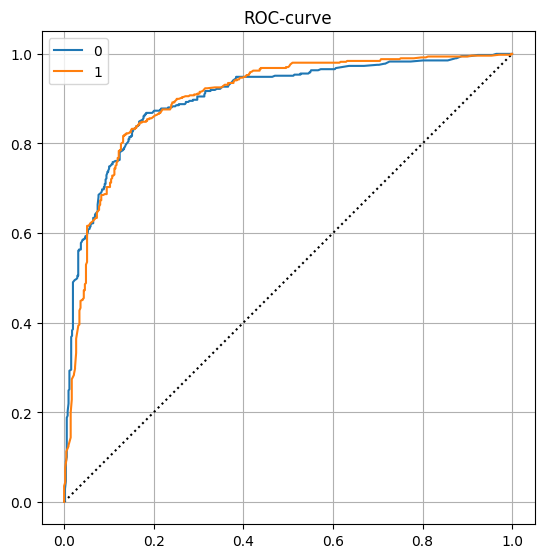

In [36]:
# Selecting the features I want the model to use
X_select = X_processed.loc[:, ["ST_Slope_Up", "ChestPainType_ASY", "ExerciseAngina_Y", "MaxHR"]]

model = GaussianNB().fit(X_select, y)
y_prob = model.predict_proba(X_select)

scores = {"label": [], "AUC": []}
plt.figure(figsize=(6.4, 6.4))
plt.plot([0, 1], [0, 1], ":k")

for index, label in enumerate(X_processed["HeartDisease"].cat.categories):
    fpr, tpr, _ = roc_curve(y == index, y_prob[:, index])
    scores["label"].append(label)
    scores["AUC"].append(roc_auc_score(y == index, y_prob[:, index]))
    plt.plot(fpr, tpr, label=label)
plt.axis("square"); plt.grid(True); plt.title("ROC-curve"); plt.legend(); plt.show()

In [37]:
# Calculating the AUC for label 0 (no heartdisease) and 1 (heartdisease)
pd.DataFrame(scores).set_index("label")


,AUC
label,
0,0.901618
1,0.901618


**Conclusion**:
- The model differentiates well between the two labels (AUC > 0.90);
- The most important features for identifying heart disease seem to be the following: `ST_Slope_Up` `ChestPainType_ASY`, `ExerciseAngina_Y`, `MaxHR`. Notably more general aspects such as age and sex don't play as large of a role and all the most important features seem to be focused on statistics that have something to do with the heart itself.

Lastly, I will generate a confusion matrix, to get more insight into the amount of false/true positives/negatives.

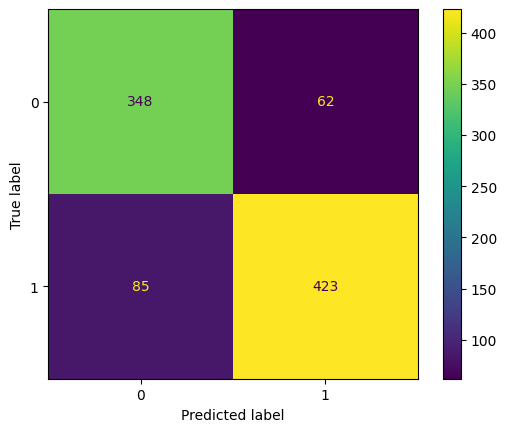

In [ ]:
y_pred = model.predict(X_select)
conf_mat = confusion_matrix(y, y_pred)

ConfusionMatrixDisplay(conf_mat, display_labels=X_processed["HeartDisease"].cat.categories).plot();

**Conclusion**:
- There are 423 true positives (the patient has heart disease and it gets correctly identified);
- There are 85 false negatives (the patient gets labeled as healthy, but has heart disease);
- There are 348 true negatives (the patient is healthy and gets correctly labeled as healthy);
- There are 62 False positives (the patient gets labeled as sick, but is healthy).

Judging from this, there seem to be **more** `false negatives` than `false positives`. Generally speaking, in a clinical setting, it is better to incorrectly label a healthy patient as sick, than miss a diagnosis by labeling a sick person as healthy. As it will get discovered that the healthy person is not actually sick, with further research, however the sick person will get sent home and the disease will not be diagnosed, which puts the patient at risk. Before implementing a model such as this one, it is important to have a low(er) `false negative rate`, as right now, using this model, approximately 17% of sick people get incorrectly labeled as healthy (85 out of total 508 people with heart disease). The `false positive rate` does not seem too high, with this model approximately 15% of healthy people get incorrectly labeled as sick (62 out of total 410 healthy people).

# Sources

- Baggiano, A., Guglielmo, M., Muscogiuri, G., Guaricci, A. I., Del Torto, A., & Pontone, G. (2020). (Epicardial and microvascular) angina or atypical chest pain: differential diagnoses with cardiovascular magnetic resonance. European Heart Journal Supplements, 22(Supplement_E), E116–E120. https://doi.org/10.1093/eurheartj/suaa075
- Baggiano, A., Guglielmo, M., Muscogiuri, G., Guaricci, A. I., Del Torto, A., & Pontone, G. (2020). (Epicardial and microvascular) angina or atypical chest pain: differential diagnoses with cardiovascular magnetic resonance. European Heart Journal Supplements, 22(Supplement_E), E116–E120. https://doi.org/10.1093/eurheartj/suaa075
- MSD Manuals. (2025, 8 maart). Calculators:Romhilt-Estes Criteria for Left Ventricular Hypertrophy-MSD Manual Professional Edition. MSD Manual Professional Edition. https://www.msdmanuals.com/professional/multimedia/clinical-calculator/romhilt-estes-criteria-for-left-ventricular-hypertrophy
- Ranjbar, A., Sohrabi, B., Sadat-Ebrahimi, S., Ghaffari, S., Kazemi, B., Aslanabadi, N., Seyvani, B., & Hajizadeh, R. (2021). The association between T wave inversion in leads with ST-elevation and patency of the infarct-related artery. BMC Cardiovascular Disorders, 21(1). https://doi.org/10.1186/s12872-021-01851-8
- pulsenotes. (n.d.). ST segment and T waves. Pulsenotes. https://app.pulsenotes.com/clinical/ecgs/notes/8-st-segment-t-waves
- MedSchool. (n.d.). The normal ECG trace. https://medschool.co/tests/ecg-basics/the-normal-ecg-trace
- Rahman, A. U., Saeed, M., Mohammed, M. A., Krishnamoorthy, S., Kadry, S., & Eid, F. (2022). An Integrated Algorithmic MADM Approach for Heart Diseases’ Diagnosis Based on Neutrosophic Hypersoft Set with Possibility Degree-Based Setting. Life, 12(5), 729. https://doi.org/10.3390/life12050729
- Fazio, S., & Linton, M. F. (2001). Debate: “How low should LDL cholesterol be lowered?” Viewpoint: “It doesn’t need to be very low”. Current Controlled Trials in Cardiovascular Medicine, 2(1). https://doi.org/10.1186/cvm-2-1-008
- Ahmed, H. M., Miller, M., Nasir, K., McEvoy, J. W., Herrington, D., Blumenthal, R. S., & Blaha, M. J. (2016). Primary Low Level of High-Density Lipoprotein Cholesterol and Risks of Coronary Heart Disease, Cardiovascular Disease, and Death: Results From the Multi-Ethnic Study of Atherosclerosis. American Journal Of Epidemiology, 183(10), 875–883. https://doi.org/10.1093/aje/kwv305
- Rawshani, A., MD PhD. (2019, 31 mei). The ST segment: physiology, normal appearance, ST depression & ST elevation. The Cardiovascular. https://ecgwaves.com/st-segment-normal-abnormal-depression-elevation-causes/